# Evaluation of Different Kernels in Support Vector Machines


#### Ruoyu Li
#### Hildebrand Department of Petroleum and Geosystems Engineering, The University of Texas at Austin
### Subsurface Machine Learning Course, The University of Texas at Austin
#### Hildebrand Department of Petroleum and Geosystems Engineering, Cockrell School of Engineering
#### Department of Geological Sciences, Jackson School of Geosciences

<br>
<br>

_____________________

Workflow supervision and review by:

#### Instructor: Prof. Michael Pyrcz, Ph.D., P.Eng., Associate Professor, The Univeristy of Texas at Austin
##### [Twitter](https://twitter.com/geostatsguy) | [GitHub](https://github.com/GeostatsGuy) | [Website](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) | [YouTube](https://www.youtube.com/channel/UCLqEr-xV-ceHdXXXrTId5ig)  | [LinkedIn](https://www.linkedin.com/in/michael-pyrcz-61a648a1)

#### Course TA: Ademide Mabadeje, Graduate Student, The University of Texas at Austin
##### [LinkedIn](https://www.linkedin.com/in/ademidemabadeje/)


__Exclusive summary__: When decision boundaries bahave non-linearly, it is necessary to project original features to a higher dimensional space. The tool for feature projection is the so-called kernels. The purpose of this workflow is to assess the decision boundaries predicted by SVM with different kernels (i.e. Linear, Polynomial, Gaussian, Laplacian, and Sigmoid kernels), while using different but representative patterns (i.e. linear, centered circular, striped, and diagonal patterns). For the convenience of visualization, patterns with only 2 dimensional original features are worked with. We will see that for patterns with linear boundaries, the other kernels outperform polynomial kernels. However, for patterns with complex boundaries, polynomial kernels and RBF kernels usually outperform the linear kernel and Sigmoid kernel.

#### Import Packages
First, we need to import standard packages. Note that 'sklearn' provides powerful and well-packaged functions for training and testing with SVM methods, together with selectable kernels built-in, which significantly facilitates our workflow.

In [1]:
import os                                                   # to set current working directory 
import numpy as np                                          # arrays and matrix math
from numpy import unravel_index
import pandas as pd                                         # DataFrames
from matplotlib import pyplot as plt
from IPython.display import Image
from IPython.core.display import HTML 
#sns.set()                                                   # Setting seaborn as default style even if use only matplotlib
import seaborn as sns                                       # for data visualization
from sklearn.svm import SVC                                 # support vector machine methods
from sklearn.model_selection import train_test_split        # training and testing datasets
from sklearn.metrics import confusion_matrix                # for sumarizing model performance
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import pairwise
scaler = StandardScaler()

#### Declare Functions 
The following code block is from Professor Michael Pyrcz (@GeostatsGuy), SubSurfuceDataAnalytics_SupportVectorMachines.ipynb from [GeostatsGuy GitHub](https://github.com/GeostatsGuy/PythonNumericalDemos/blob/master/SubsurfaceDataAnalytics_SupportVectorMachines.ipynb).
These functions facilitate the visualization processes.

In [2]:
def visualize_model(model,nxfeature,nyfeature,xfeature,yfeature,response):# plots the data points and the decision tree prediction 
    n_classes = 10
    cmap = plt.cm.coolwarm
    x_min, x_max = min(nxfeature), max(nxfeature) 
    y_min, y_max = min(nyfeature) , max(nyfeature) 
    plot_step = 100
    resp_min = round(min(response)); resp_max = round(max(response));
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, plot_step),
                     np.linspace(y_min, y_max, plot_step))
    
    z_min = round(min(response)); z_max = round(max(response))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])

    Z = Z.reshape(xx.shape)
    trans = scaler.inverse_transform(np.c_[xx.ravel(), yy.ravel()])
    trans_x = trans[:,0].reshape(xx.shape)
    trans_y = trans[:,1].reshape(xx.shape)
    cs = plt.contourf(trans_x, trans_y, Z, cmap=cmap,vmin=z_min, vmax=z_max)

    im = plt.scatter(xfeature,yfeature,s=None, c=response, marker=None, cmap=cmap, norm=None, vmin=z_min, vmax=z_max, alpha=0.8, linewidths=0.3, edgecolors="black")
    plt.xlabel(xfeature.name)
    plt.ylabel(yfeature.name)
    cbar = plt.colorbar(im, orientation = 'vertical')
    cbar.set_label(response.name, rotation=270, labelpad=20)
    return(plt)

def plot_svc_decision_function(model,plt, plot_support=True): # modified from Jake VanderPlas's Python Data Science Handbook  
    """Plot the decision function for a 2D SVC"""
    xlim = [-2.5,2.5]
    ylim = [-2.5,2.5]
    # plot support vectors
    sv = scaler.inverse_transform(model.support_vectors_)
    if plot_support:
        plt.scatter(sv[:, 0],
                   sv[:, 1],
                   s=3, linewidth=8,alpha = 0.6, facecolors='black');

#### Set the working directory

In [3]:
#os.chdir("D:\ML_EXERCISE\Project Demo")                     # set the working directory

#### Loading Data
Let's load the provided multivariate, spatial dataset 'Modified_12_sample_data.csv'.  It is a comma delimited file which is modified from '12_sample_data.csv' provided by Dr. Pyrcz. It contains: 

* X and Y coordinates ($m$)
* original facies 0 and 1 
* porosity (fraction)
* permeability ($mD$)
* acoustic impedance ($\frac{kg}{m^3} \cdot \frac{m}{s} \cdot 10^3$). 
* circular pattern facies 0 and 1
* stripe pattern facies 0 and 1
* diagonal pattern facies 0 and 1

We would like to put our data in Pandas Dataframe to facilitate further operations.

In [4]:
df = pd.read_csv(r"https://raw.githubusercontent.com/Ruoyu66666/SVM_KernelTrickEvaluation/e64bb3bab32da44d081f09cc37780317917ae403/Modified_12_sample_data.csv")                      # read a .csv file in as a DataFrame

We then do a quick review of our dataframe.

In [5]:
df.head(n=13)

X    Y  Facies  Porosity         Perm           AI  Cir_PT  Stripe_PT  \
0    50  900       1  0.220761   140.021266  3413.063944       0          0   
1    50  850       1  0.237154    39.837129  3074.562617       0          0   
2    50  800       1  0.234352    84.992437  2292.783358       0          0   
3    50  750       1  0.244553    90.632307  2494.848885       0          0   
4    50  700       1  0.231787   811.547979  2522.063995       0          0   
5    50  650       1  0.233280   426.992456  3964.185956       0          0   
6    50  550       1  0.234423  2398.406492  3318.885844       0          0   
7    50  500       1  0.219657  1637.224971  3030.874323       0          1   
8    50  450       1  0.200389   265.636019  3454.389302       1          1   
9    50  350       0  0.165908     7.951511  5025.286221       0          1   
10   50  300       0  0.155199     1.476967  4939.312852       0          0   
11   50  150       0  0.175103     5.476548  4770.744199       0          1   
12  100  950       1  0.202124   357.481641  3383.118632       1          1   

    Diag_PT  
0         0  
1         0  
2         1  
3         1  
4         1  
5         0  
6         0  
7         1  
8         1  
9         1  
10        1  
11        1  
12        1

#### Summary Statistics for Tabular Data

It is then necessary to examine the summary statistics our source data. Since porosity and acoustic impedence data are used, we need to ensure they do not possess negative outliers. It is also necessary to check our facies indices and make sure they are binary integers.

In [6]:
df.describe().transpose()

count         mean          std          min          25%  \
X          480.0   430.187500   263.832692     0.000000   200.000000   
Y          480.0   522.166667   284.293420    19.000000   279.000000   
Facies     480.0     0.616667     0.486706     0.000000     0.000000   
Porosity   480.0     0.189440     0.031702     0.117562     0.165884   
Perm       480.0   520.932093  1226.207190     0.005776     6.539988   
AI         480.0  3758.879653   779.990582  1746.387548  3212.900120   
Cir_PT     480.0     0.297917     0.457820     0.000000     0.000000   
Stripe_PT  480.0     0.587500     0.492798     0.000000     0.000000   
Diag_PT    480.0     0.458333     0.498781     0.000000     0.000000   

                   50%          75%           max  
X           390.000000   630.000000    980.000000  
Y           539.000000   759.000000    999.000000  
Facies        1.000000     1.000000      1.000000  
Porosity      0.185443     0.216513      0.261091  
Perm         49.451463   369.470756  10319.904850  
AI         3719.883000  4236.160395   6194.573653  
Cir_PT        0.000000     1.000000      1.000000  
Stripe_PT     1.000000     1.000000      1.000000  
Diag_PT       0.000000     1.000000      1.000000

#### Visualization of Loaded Data

We will do further visual data inspection by plotting porosity and acoustic impedence with the associated facies. We are using seaborn package to do scatter plot with categorical data like facies.

Text(0.5, 1.0, 'Diagonal facies pattern')

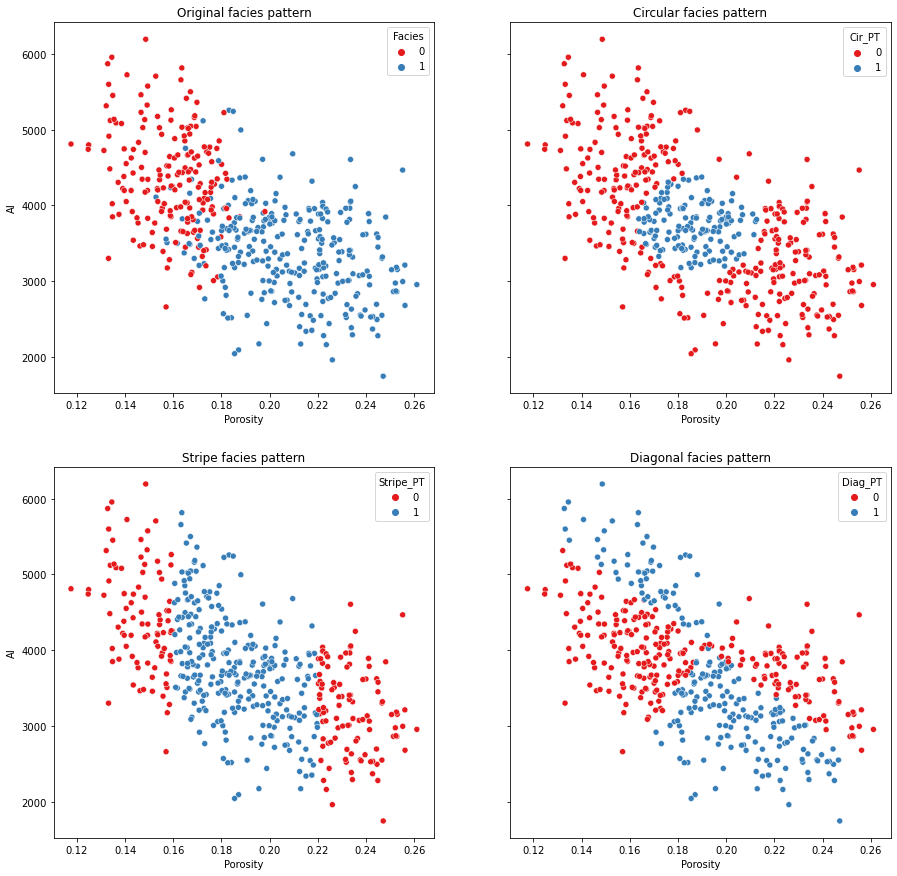

In [7]:
fig, axes = plt.subplots(2, 2, figsize=(15, 15), sharey=True)

sns.scatterplot(ax=axes[0,0],x = 'Porosity', y = 'AI', hue='Facies',data=df,legend='full',palette = "Set1")
axes[0,0].set_title('Original facies pattern')
sns.scatterplot(ax=axes[0,1],x = 'Porosity', y = 'AI', hue='Cir_PT',data=df,legend='full',palette = "Set1")
axes[0,1].set_title('Circular facies pattern')
sns.scatterplot(ax=axes[1,0],x = 'Porosity', y = 'AI', hue='Stripe_PT',data=df,legend='full',palette = "Set1")
axes[1,0].set_title('Stripe facies pattern')
sns.scatterplot(ax=axes[1,1],x = 'Porosity', y = 'AI', hue='Diag_PT',data=df,legend='full',palette = "Set1")
axes[1,1].set_title('Diagonal facies pattern')

Our porosity and acoustic impedence data look good, together with four types of facies assignments.

#### Standardization of Loaded Data

SVMs assume that the data it works with is in a standard range, usually -1 to 1 (roughly) (Dr.Pyrcz, Michael). Distances within the margins are involved in the calculation of loss function. Thus, it is necessary to standardize our predictor features prior to training and testing processes.

In [8]:
xx = scaler.fit_transform(df.loc[:,['Porosity','AI']])  ### standardize all the data
df['nPorosity'] = xx[:,0]
df['nAI'] = xx[:,1]
df.head()

X    Y  Facies  Porosity        Perm           AI  Cir_PT  Stripe_PT  \
0  50  900       1  0.220761  140.021266  3413.063944       0          0   
1  50  850       1  0.237154   39.837129  3074.562617       0          0   
2  50  800       1  0.234352   84.992437  2292.783358       0          0   
3  50  750       1  0.244553   90.632307  2494.848885       0          0   
4  50  700       1  0.231787  811.547979  2522.063995       0          0   

   Diag_PT  nPorosity       nAI  
0        0   0.989042 -0.443821  
1        0   1.506684 -0.878255  
2        1   1.418176 -1.881594  
3        1   1.740311 -1.622263  
4        1   1.337183 -1.587335

#### Support Vector Machine Model with for Linear Kernel

To make our workflow as compact as possible, we utilize the built-in function named 'StratifiedShuffleSplit' to do random train-test split for multiple times. Then, we use 'GridSearchCV.fit' to train our SVM model with the assigned kernel type and a range of hyperparameter 'C'. Last, we use 'GridSearchCV.cv_results_' to average our testing score for each train-test split.
<br>
<br>
The following code block is modified from Professor Michael Pyrcz (@GeostatsGuy), SubSurfuceDataAnalytics_SupportVectorMachines.ipynb from [GeostatsGuy GitHub](https://github.com/GeostatsGuy/PythonNumericalDemos/blob/master/SubsurfaceDataAnalytics_SupportVectorMachines.ipynb).
<br>
<br>
Let's first train, test and tune the original pattern! (Note this code block will run for quite a while.)

In [13]:
C_range = np.logspace(-2, 8, 11)
param_grid = dict(C=C_range)
cv = StratifiedShuffleSplit(n_splits=5, test_size=0.3, random_state=4) #random train-test split for 5 times
grid = GridSearchCV(SVC(kernel = 'linear'), param_grid=param_grid, cv=cv)
grid.fit(df.loc[:,['nPorosity','nAI']], df['Facies'])
scores = grid.cv_results_['mean_test_score']

Let us then visualize the mean testing score versus our hyperparameter 'C'.

No handles with labels found to put in legend.


Text(0.5, 1.0, 'Hyperparameter C Tuning based on Mean Test Score')

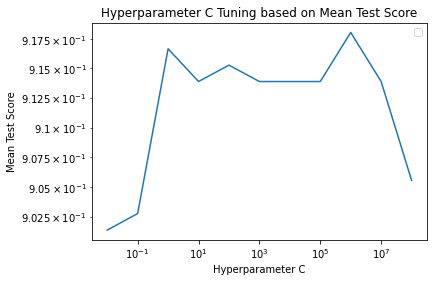

In [15]:
plt.loglog(C_range, scores)
plt.xlabel("Hyperparameter C")
plt.ylabel("Mean Test Score")
plt.legend()
plt.title("Hyperparameter C Tuning based on Mean Test Score")

We see when C=10^6, the performance of our model reaches the optimum. Let's retrain our model on the whole dataset and visualize our model with linear kernel! 

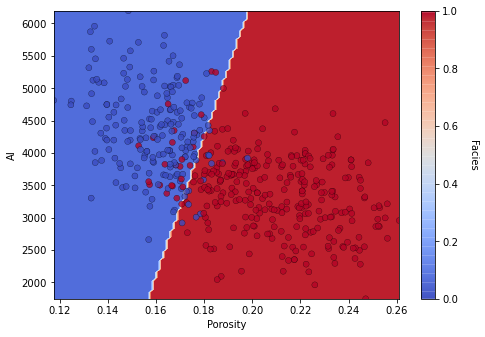

In [14]:
C10 = 10**6
svm_linear10 = SVC(kernel = 'linear',C = C10, random_state = 0)    # Create a SVC classifier using a linear kernel
svm_linear10.fit(df.loc[:,['nPorosity','nAI']], df.loc[:,'Facies'])    # Train the classifier
plt = visualize_model(svm_linear10,df["nPorosity"],df["nAI"],df["Porosity"],df["AI"],df["Facies"])
plot_svc_decision_function(svm_linear10,plt,plot_support=False)

plt.subplots_adjust(left=0.0, bottom=0.0, right=1.0, top=1.0, wspace=0.2, hspace=0.2)

Note that the points with bold boundaries are the support vectors. Only points within the margin (or beyond the margin at the wrong side) are accounted for the behavior of our decision boundary.
SVM with linear kernel does work well on patterns with linear decision boundary.
We will then try polynomial kernels and RBF kernels.

#### Support Vector Machine Model with Polynomial Kernel

We use polynomial kernel to project the 2 dimensional predictor features to higher dimensional space which is non-linear. The SVM model will then capture the non-linearity by fitting the linearity in the higher dimensional space.
The polynomial kernel is defined as

\begin{equation}
K(x,x') = (x^Tx)^d,
\end{equation}

where $d$ is the degree of polynomials.

The parameter 'C' controls the penalty of misclassification. High 'C' will result in a more complicated model which potentially tends to overfit. 

The degree 'd' is to control the order of the polynomial kernel function. The increase of the degree will explicitly increase model complexity.

Before using the compact train-test-tune code block, we will first try to train with several sets of hyperparameters. This will help us to filter out the ineffective kernels and significantly save our time for hyperparameter tuning.

Our trials contains 10 combinations: C=[1,100] and d=[2,3,4,5,6].

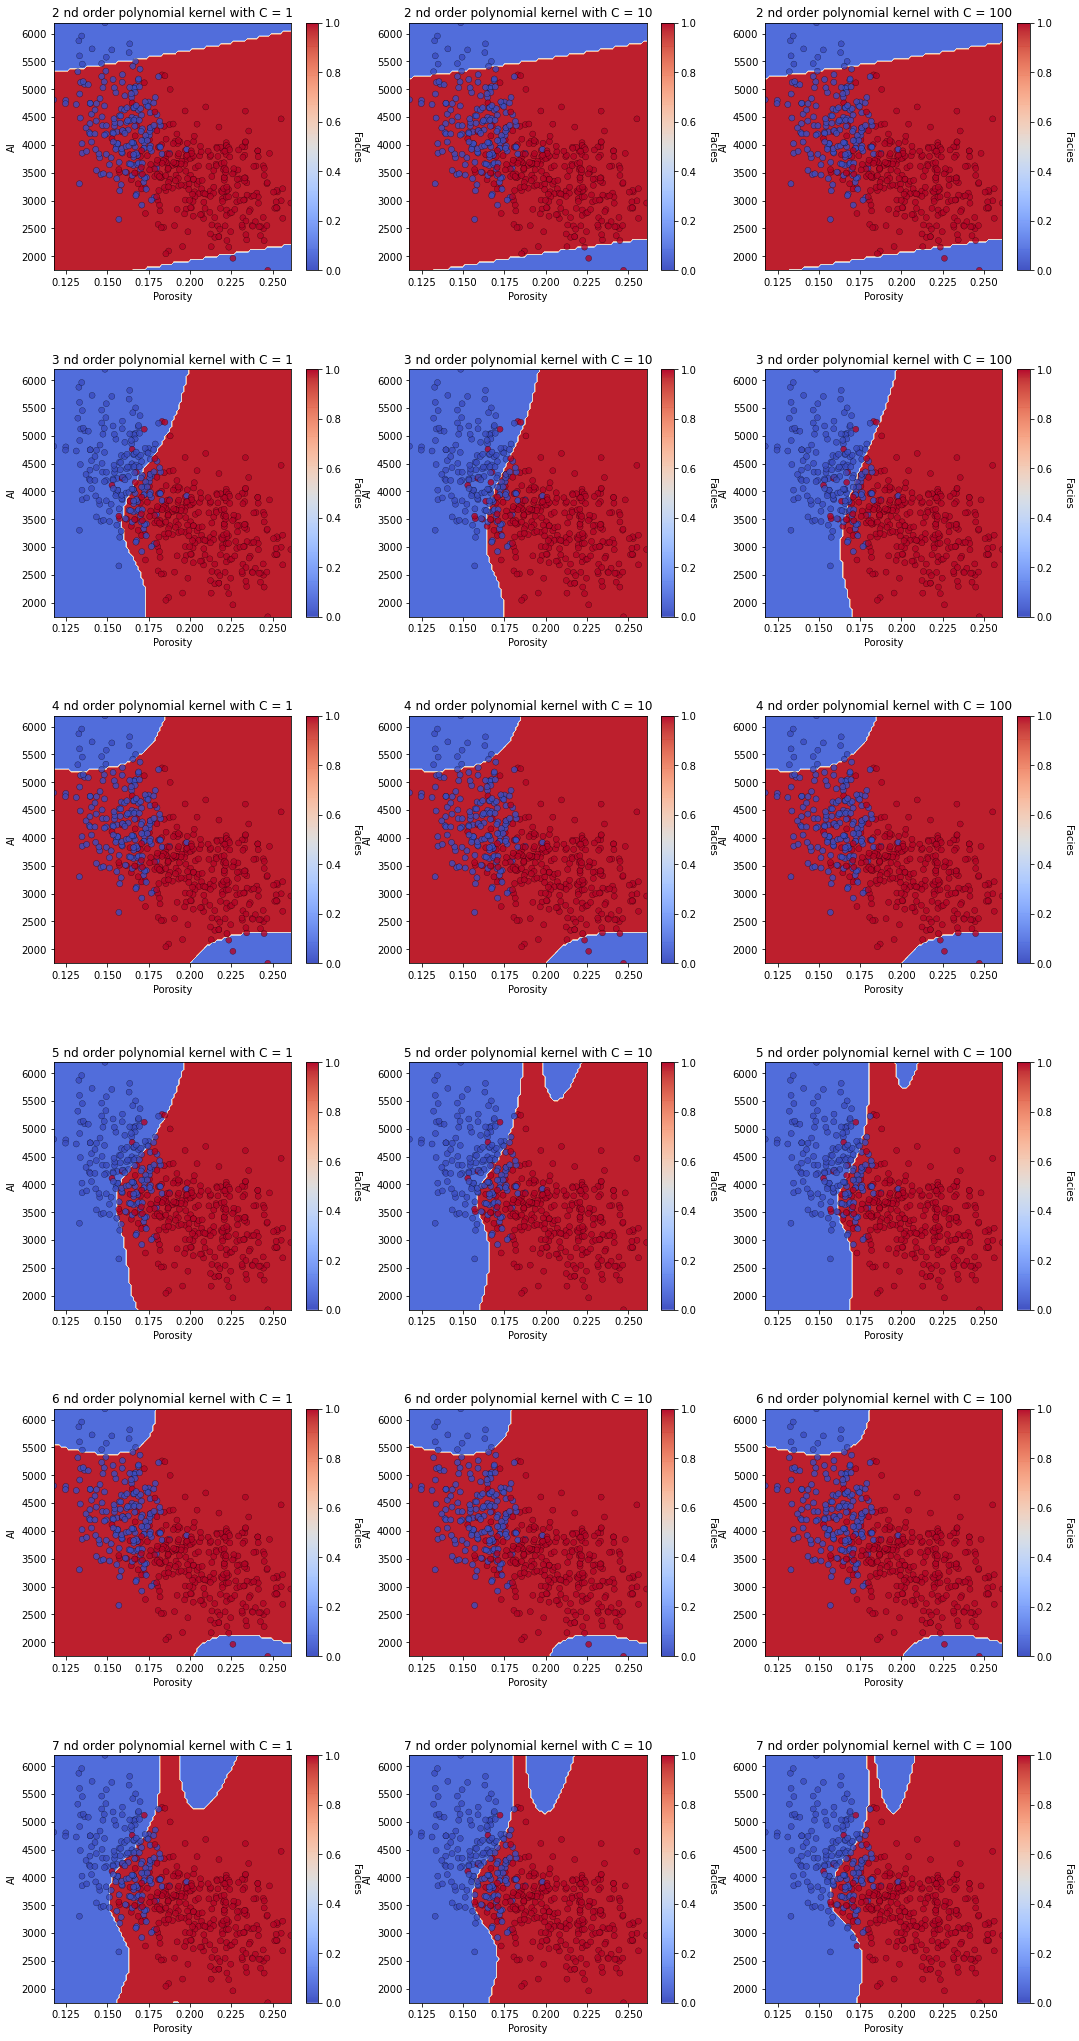

In [16]:
Carr=np.array([1,10,100])
darr=np.array([2,3,4,5,6,7])
shc=int(np.shape(Carr)[0])
shd=int(np.shape(darr)[0])
plt.figure(figsize=(7, 11))

for j in range(shd):
    for i in range(shc):
        k=i+j*shc
        svm_poly = SVC(kernel = 'poly', degree = darr[j], random_state=0,C = Carr[i])
        svm_poly.fit(df.loc[:,['nPorosity','nAI']], df.loc[:,'Facies'])
        plt.subplot(shd,shc,k+1)
        plt = visualize_model(svm_poly,df["nPorosity"],df["nAI"],df["Porosity"],df["AI"],df["Facies"])
        plt.title(str(darr[j])+' nd order polynomial kernel with C = '+str(Carr[i]))
        plot_svc_decision_function(svm_poly,plt, plot_support=False)
plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=2.5, wspace=0.2, hspace=0.4)

It is surprising to see that for even polynomial degrees, the SVM barely fits the decision boundary! This is independent of the value of hyperparameter 'C'. We could then only train-test-tune our hyperparameters for odd polynomial degrees.

In [20]:
scrs = np.zeros((3,9))
deg = np.array([3,5,7])                                                      #polynomial degree for the kernel: 3,5,7
j = 0
for i in deg:
    C_range = np.logspace(-2,6,9)
    degree_range = np.array([i])
    param_grid = dict(degree = degree_range,C = C_range)
    cv = StratifiedShuffleSplit(n_splits=5, test_size=0.3, random_state=4) #random train-test split for 5 times
    grid = GridSearchCV(SVC(kernel = 'poly'), param_grid=param_grid, cv=cv)
    grid.fit(df.loc[:,['nPorosity','nAI']], df['Facies'])
    scrs[j,:] = grid.cv_results_['mean_test_score']
    j += 1

Let us visualize the test score for three types of polynomial kernels.

Text(0.5, 1.0, 'Hyperparameter C Tuning based on Mean Test Score')

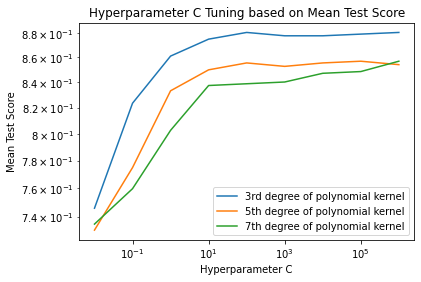

In [21]:
plt.loglog(C_range, scrs[0,:], label='3rd degree of polynomial kernel')
plt.loglog(C_range, scrs[1,:], label='5th degree of polynomial kernel')
plt.loglog(C_range, scrs[2,:], label='7th degree of polynomial kernel')
plt.xlabel("Hyperparameter C")
plt.ylabel("Mean Test Score")
plt.legend()
plt.title("Hyperparameter C Tuning based on Mean Test Score")

We find that the SVM model with hyperparameter 'C'=100 and polynomial degree=3 is the optimum. We would then train all the data using this set of hyperparameters and visualize our model with data.

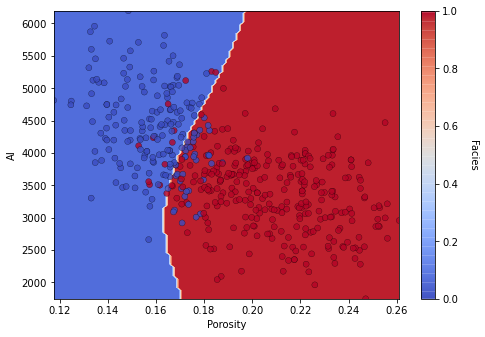

In [22]:
C = 100
svm_poly3_C100 = SVC(kernel = 'poly', degree = 3, random_state=0, C = C)
svm_poly3_C100.fit(df.loc[:,['nPorosity','nAI']], df.loc[:,'Facies'])
plt = visualize_model(svm_poly3_C100,df["nPorosity"],df["nAI"],df["Porosity"],df["AI"],df["Facies"])
plot_svc_decision_function(svm_poly3_C100,plt,plot_support=False)

plt.subplots_adjust(left=0.0, bottom=0.0, right=1.0, top=1.0, wspace=0.2, hspace=0.2)

We note that for patterns with linear decision boundaries, polynomial kernels with low degrees can still perform well. Let us also see the overfit if we use a kernel degree=9.

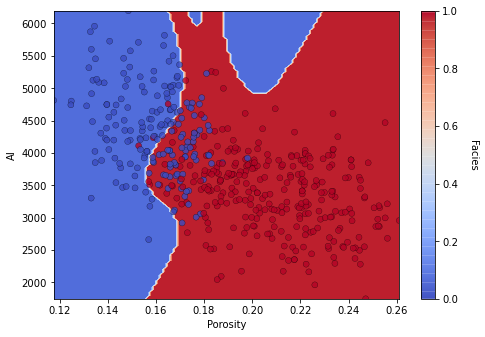

In [23]:
C = 100
svm_poly9_C100 = SVC(kernel = 'poly', degree = 9, random_state=0, C = C)
svm_poly9_C100.fit(df.loc[:,['nPorosity','nAI']], df.loc[:,'Facies'])
plt = visualize_model(svm_poly9_C100,df["nPorosity"],df["nAI"],df["Porosity"],df["AI"],df["Facies"])
plot_svc_decision_function(svm_poly9_C100,plt,plot_support=False)

plt.subplots_adjust(left=0.0, bottom=0.0, right=1.0, top=1.0, wspace=0.2, hspace=0.2)

The overfit becomes quite significant. Let us also decrease hyperparameter 'C' to 0.01 with the best kernel of degree 3 and visualize the underfit.

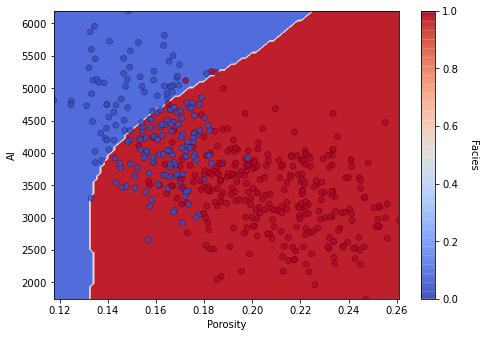

In [24]:
C = 0.01
svm_poly3_C100 = SVC(kernel = 'poly', degree = 3, random_state=0, C = C)
svm_poly3_C100.fit(df.loc[:,['nPorosity','nAI']], df.loc[:,'Facies'])
plt = visualize_model(svm_poly3_C100,df["nPorosity"],df["nAI"],df["Porosity"],df["AI"],df["Facies"])
plot_svc_decision_function(svm_poly3_C100,plt,plot_support=False)

plt.subplots_adjust(left=0.0, bottom=0.0, right=1.0, top=1.0, wspace=0.2, hspace=0.2)

Notice that the margin becomes very wide. It means the error tolerance becomes very high, resulting in potential underfit.

#### Support Vector Machine Model with Gaussian Kernel

The following introduction of RBF is quoted from Professor Michael Pyrcz (@GeostatsGuy), SubSurfuceDataAnalytics_SupportVectorMachines.ipynb from [GeostatsGuy GitHub](https://github.com/GeostatsGuy/PythonNumericalDemos/blob/master/SubsurfaceDataAnalytics_SupportVectorMachines.ipynb).

Radial Basis Function (RBF) is another commonly used kernel in SVC:

\begin{equation}
K(x,x') = e^{- \gamma ||x-x'||^2},
\end{equation}

where $||x-x'||^2$ is the squared Euclidean distance between two data points x and x'. 

Gaussian kernel is a special case of RBF, where: 

\begin{equation}
K(x,x') = e^{- \frac {||x-x'||^2} {2 \sigma^2}}.
\end{equation}

By changing the value of $\gamma$ and C, the classifier with an RBF kernel can be tuned.

$\gamma$ can be thought of as the spread of the kernel. 

* When $\gamma$ is low, the curve of the decision boundary is low and lead to a broad decision region (low variance, high bias)

* The $\gamma$ parameter can be seen as the inverse of the radius of influence of samples selected by the model as support vectors.

Now we have 2 hyperparameters: C and $\gamma$. Again, we want to first train and visualize our model with several hyperparameter combinations.

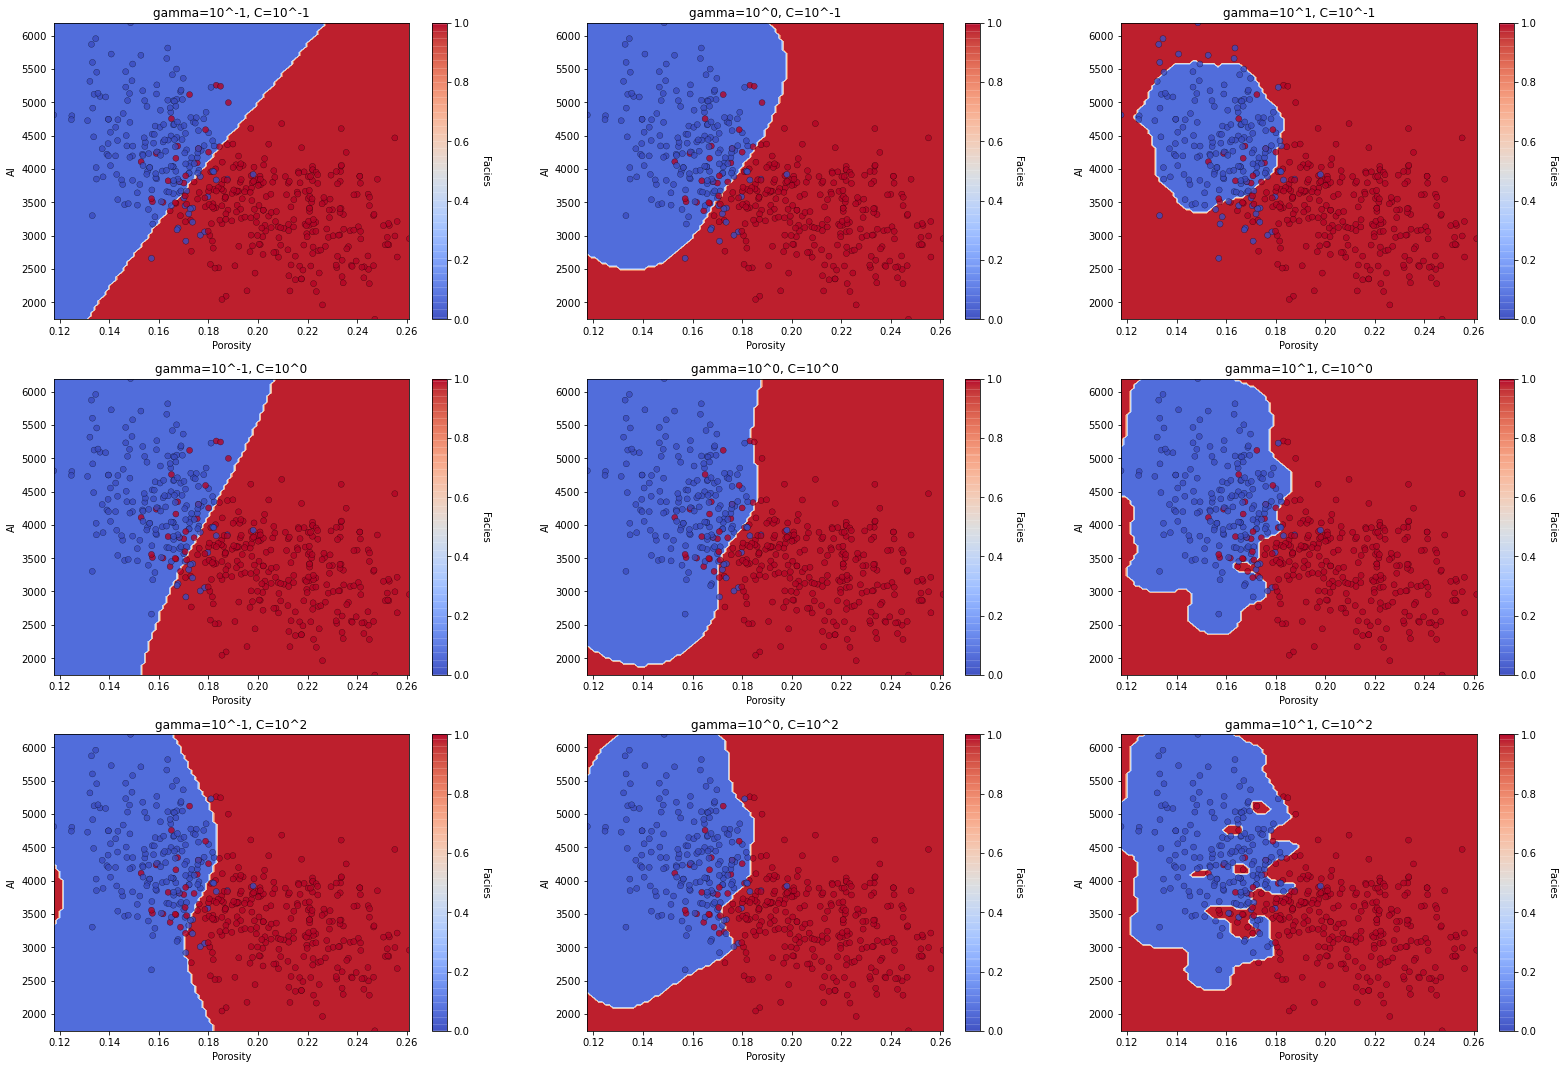

In [25]:
#This code block is modified from from Professor Michael Pyrcz (@GeostatsGuy), SubSurfuceDataAnalytics_SupportVectorMachines.ipynb from GeostatsGuy GitHub.
C_2d_range = [1e-1, 1, 1e2]
gamma_2d_range = [1e-1, 1, 1e1]
classifiers = []
for C in C_2d_range:
    for gamma in gamma_2d_range:
        clf = SVC(kernel = 'rbf',C=C, gamma=gamma)
        clf.fit(df.loc[:,['nPorosity','nAI']], df.loc[:,'Facies'])
        classifiers.append((C, gamma, clf))
for (k, (C, gamma, clf)) in enumerate(classifiers):
    plt.subplot(len(C_2d_range), len(gamma_2d_range), k + 1)
    plt = visualize_model(clf,df["nPorosity"],df["nAI"],df["Porosity"],df["AI"],df["Facies"])
    plot_svc_decision_function(clf,plt,plot_support=False)
    plt.title("gamma=10^%d, C=10^%d" % (np.log10(gamma), np.log10(C)))
plt.subplots_adjust(left=0.0, bottom=0.0, right=3.5, top=3.5, wspace=0.2, hspace=0.2)

It is nice to see our hyperparameter trials cover the hyperparameter spaces from undertif to overfit. We will then use the compact code to train-test-tune our model.

In [26]:
#This code block is modified from from Professor Michael Pyrcz (@GeostatsGuy), SubSurfuceDataAnalytics_SupportVectorMachines.ipynb from GeostatsGuy GitHub.
C_range = np.logspace(-2, 10, 13)
gamma_range = np.logspace(-9, 3, 13)
param_grid = dict(gamma=gamma_range, C=C_range)
cv = StratifiedShuffleSplit(n_splits=5, test_size=0.3, random_state=4) #random train-test split for 5 times
grid = GridSearchCV(SVC(), param_grid=param_grid, cv=cv)
grid.fit(df.loc[:,['nPorosity','nAI']], df['Facies'])
scores = grid.cv_results_['mean_test_score'].reshape(len(C_range),len(gamma_range))

We will visualize the test scores with respect to hyperparameter spaces.

Text(0.5, 1.0, 'Validation accuracy')

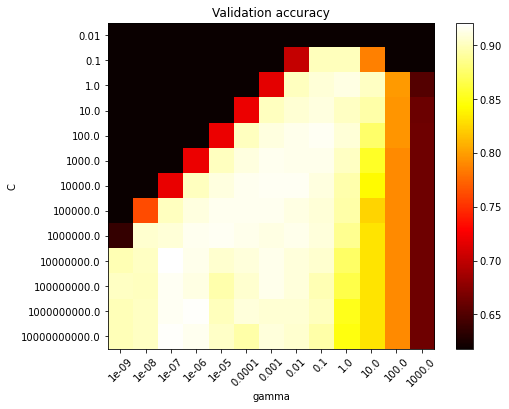

In [27]:
#This code block is modified from from Professor Michael Pyrcz (@GeostatsGuy), SubSurfuceDataAnalytics_SupportVectorMachines.ipynb from GeostatsGuy GitHub.
plt.figure(figsize=(8, 6))    
plt.imshow(scores, cmap=plt.cm.hot)
plt.xlabel('gamma')
plt.ylabel('C')
plt.colorbar()
plt.xticks(np.arange(len(gamma_range)), gamma_range, rotation=45)
plt.yticks(np.arange(len(C_range)), C_range)
plt.title('Validation accuracy')

We need to find our optimum hyperparameter combination.

In [28]:
print('The maximum score is: ' + str(np.max(scores)) + '.')
print('The position of maximum score is: '+str(unravel_index(scores.argmax(), scores.shape))+'.')

The maximum score is: 0.9208333333333332.
The position of maximum score is: (9, 2).


Our optimum hyperparameter set is C=1.0, gamma=1.0. We then visualize our optimized model using all the dataset.

SVC(C=1, gamma=1)


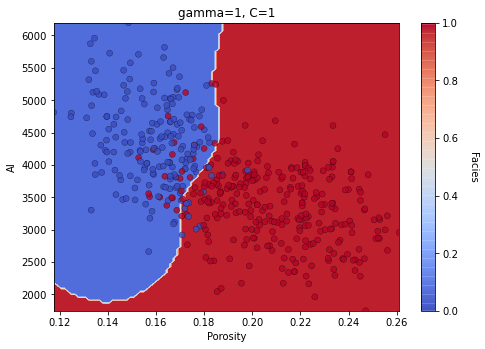

In [31]:
C=1
gamma=1
clf = SVC(kernel = 'rbf',C=C, gamma=gamma)
clf.fit(df.loc[:,['nPorosity','nAI']], df.loc[:,'Facies'])
plt = visualize_model(clf,df["nPorosity"],df["nAI"],df["Porosity"],df["AI"],df["Facies"])
plot_svc_decision_function(clf,plt,plot_support=False)

plt.title("gamma=1, C=1")
plt.subplots_adjust(left=0.0, bottom=0.0, right=1.0, top=1.0, wspace=0.2, hspace=0.2)
print(clf)

The decision boundary looks good.

#### Support Vector Machine Model with Laplacian Kernel

Laplacian kernel is another type of Radial Basis Function (RBF):

\begin{equation}
K(x,x') = e^{- \gamma ||x-x'||},
\end{equation}

where $||x-x'||$ is the Euclidean distance between two data points x and x'. 

The differences from the Gaussian kernel are the 1st order of Euclidean distance and the representation of $\gamma$: 

\begin{equation}
K(x,x') = e^{- \frac {||x-x'||} { \sigma}}.
\end{equation}

Compared to the Gaussian kernel, Laplacian kernel is less sensitive to the inter-point distance, which can potentially decrease model variance, similar to where L1 norm outperforms L2 norm.

By changing the value of $\gamma$ and C, the classifier with an RBF kernel can be tuned. 

Again, we want to first train and visualize our model with several hyperparameter combinations.

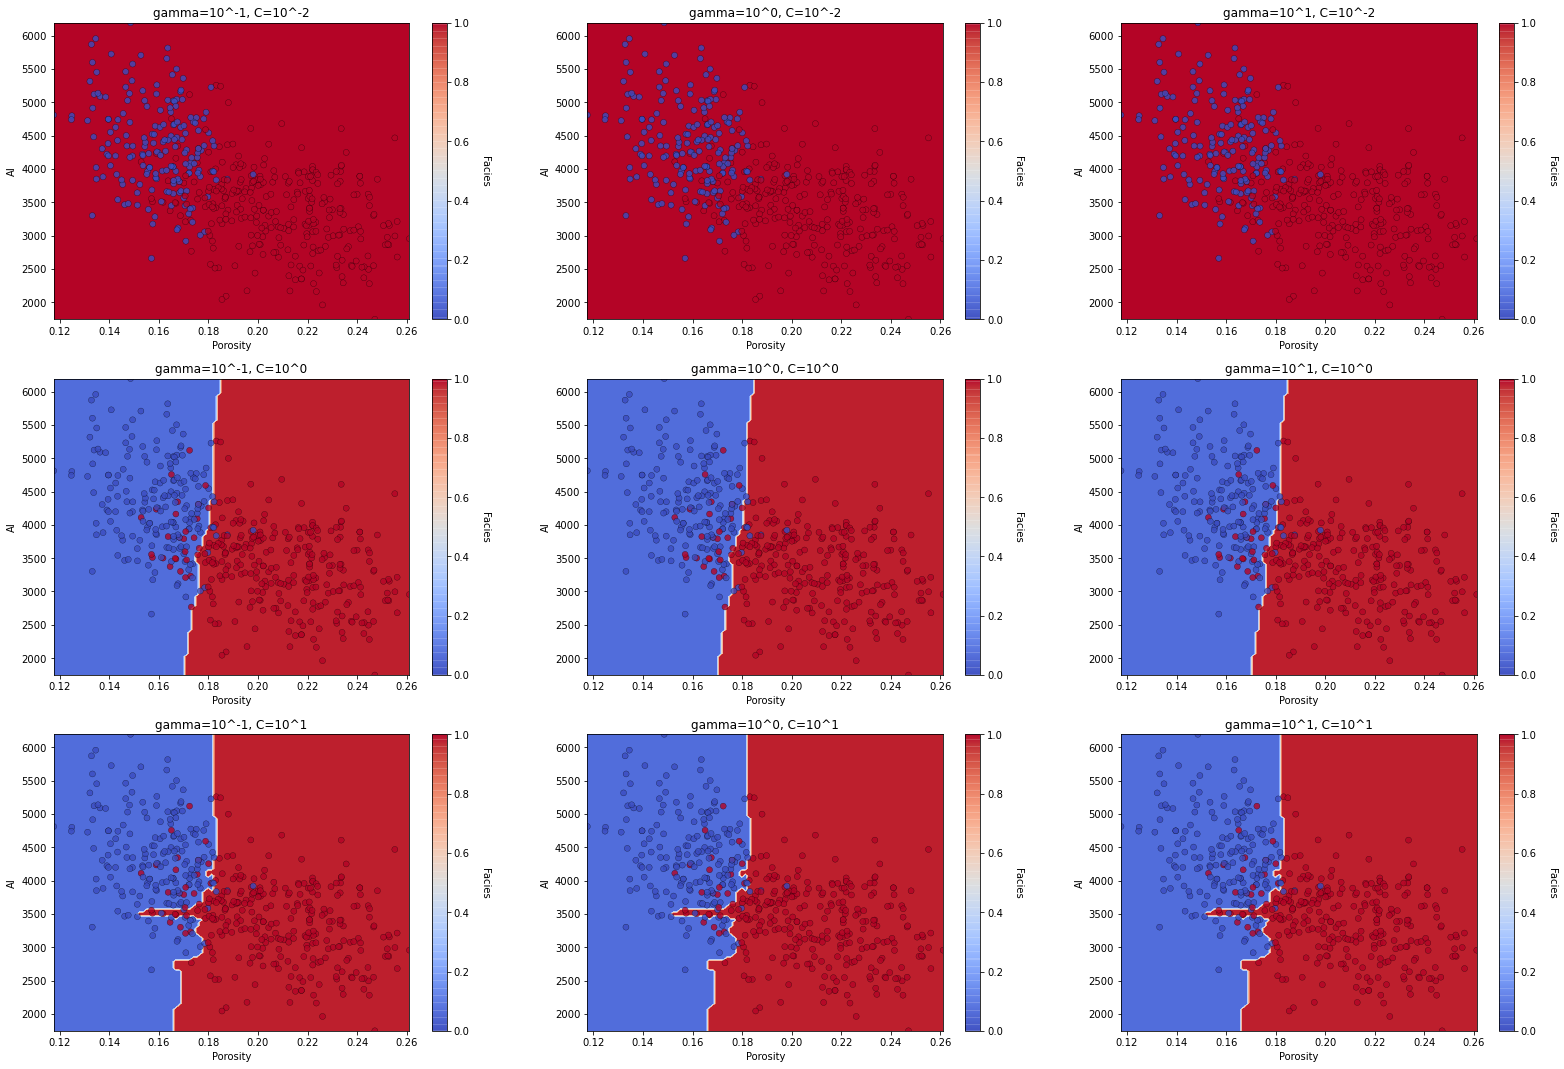

In [32]:
C_range = [1e-2, 1, 1e1]
gamma_range = [1e-1, 1, 1e1]
classifiers = []
for C in C_range:
    for gamma in gamma_range:
        clf = SVC(kernel = pairwise.laplacian_kernel, gamma=gamma,C=C)
        clf.fit(df.loc[:,['nPorosity','nAI']], df.loc[:,'Facies'])
        classifiers.append((C, gamma, clf))
for (k, (C, gamma, clf)) in enumerate(classifiers):
    plt.subplot(len(C_range), len(gamma_range), k + 1)
    plt = visualize_model(clf,df["nPorosity"],df["nAI"],df["Porosity"],df["AI"],df["Facies"])
    plt.title("gamma=10^%d, C=10^%d" % (np.log10(gamma), np.log10(C)))
plt.subplots_adjust(left=0.0, bottom=0.0, right=3.5, top=3.5, wspace=0.2, hspace=0.2)

In these trial plots, the effect of $\gamma$ is not seeable. Note that a precomputed kernel indicated by pairwise.laplacian_kernel is used. We assume here the actual used gamma is the default value (= 1/2), or less likely that $\gamma$ is not a sensitive hyperparameter. And as expected, higher C will result in overfit. Also, C cannot be too small, like 0.01 or smaller. We will then start train-test-tune our model.

In [33]:
Carr = np.logspace(-2, 4, 7)
gammaarr = np.logspace(-2, 4, 7)
param_grid = dict(gamma=gammaarr, C=Carr)
cv = StratifiedShuffleSplit(n_splits=5, test_size=0.3, random_state=4) #random train-test split for 5 times
grid = GridSearchCV(SVC(kernel = pairwise.laplacian_kernel), param_grid=param_grid, cv=cv)
grid.fit(df.loc[:,['nPorosity','nAI']], df['Facies'])
scores = grid.cv_results_['mean_test_score'].reshape(len(Carr),len(gammaarr))

Text(0.5, 1.0, 'Validation accuracy')

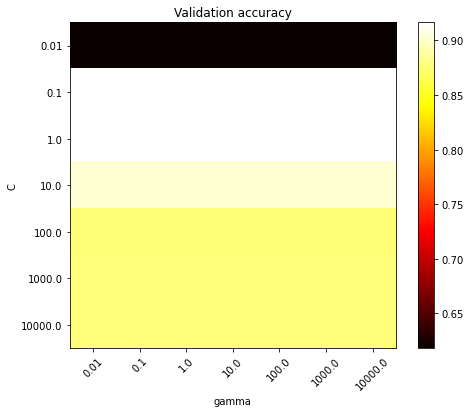

In [34]:
plt.figure(figsize=(8, 6))    
plt.imshow(scores, cmap=plt.cm.hot)
plt.xlabel('gamma')
plt.ylabel('C')
plt.colorbar()
plt.xticks(np.arange(len(gammaarr)), gammaarr, rotation=45)
plt.yticks(np.arange(len(Carr)), Carr)
plt.title('Validation accuracy')

As expected, gamma seems unchanged in our model. The optimum hyperparameter C is 0.1 or 1.0. Our tuned model looks like:

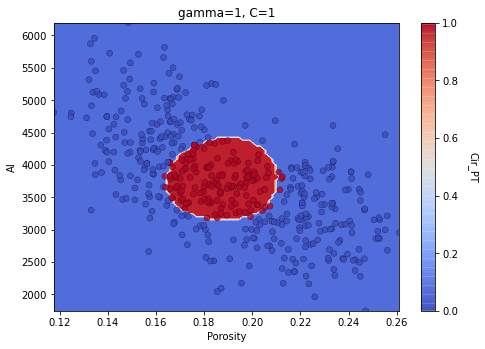

In [35]:
C=0.1
gamma=1
clf = SVC(kernel = pairwise.laplacian_kernel,C=C, gamma=gamma)
clf.fit(df.loc[:,['nPorosity','nAI']], df.loc[:,'Cir_PT'])
plt = visualize_model(clf,df["nPorosity"],df["nAI"],df["Porosity"],df["AI"],df["Cir_PT"])
plt.title("gamma=1, C=1")
plt.subplots_adjust(left=0.0, bottom=0.0, right=1.0, top=1.0, wspace=0.2, hspace=0.2)

Our decision boundary do not smooth, but does behave linearly. Using Laplacian kernel for linear decision boundary is okay.

#### Support Vector Machine Model with Sigmoid Kernel

Sigmoid is another embedded kernel in sklearn.svm.SVC:

\begin{equation}
K(x,x') = tanh({\gamma x^Tx}), \gamma>0
\end{equation}

Note that when $\gamma$ = 1, Sigmoid kernel is a direct implementation of sigmoid transformation from linear kernel. It limits the output elements in similarity matrix to (-1,1). Also, due to its low gradient at places far from the origin, the data points far from the center of the feature spaces will look adjacent even if they are actually distant from each other. We could thus expect that our predicted decision boundary are more biased towards the center.

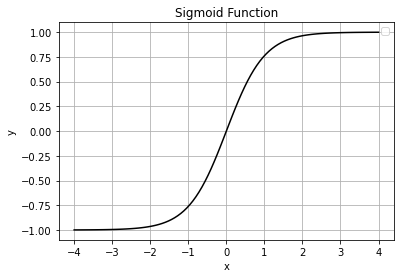

By changing the value of $\gamma$ and C, the classifier with an Sigmoid kernel can be tuned.

High $\gamma$ can make the prediced decision boundary tend to overfit. 


First, let's do some trials to visualize the effect of hyperparameters $\gamma$ and C.

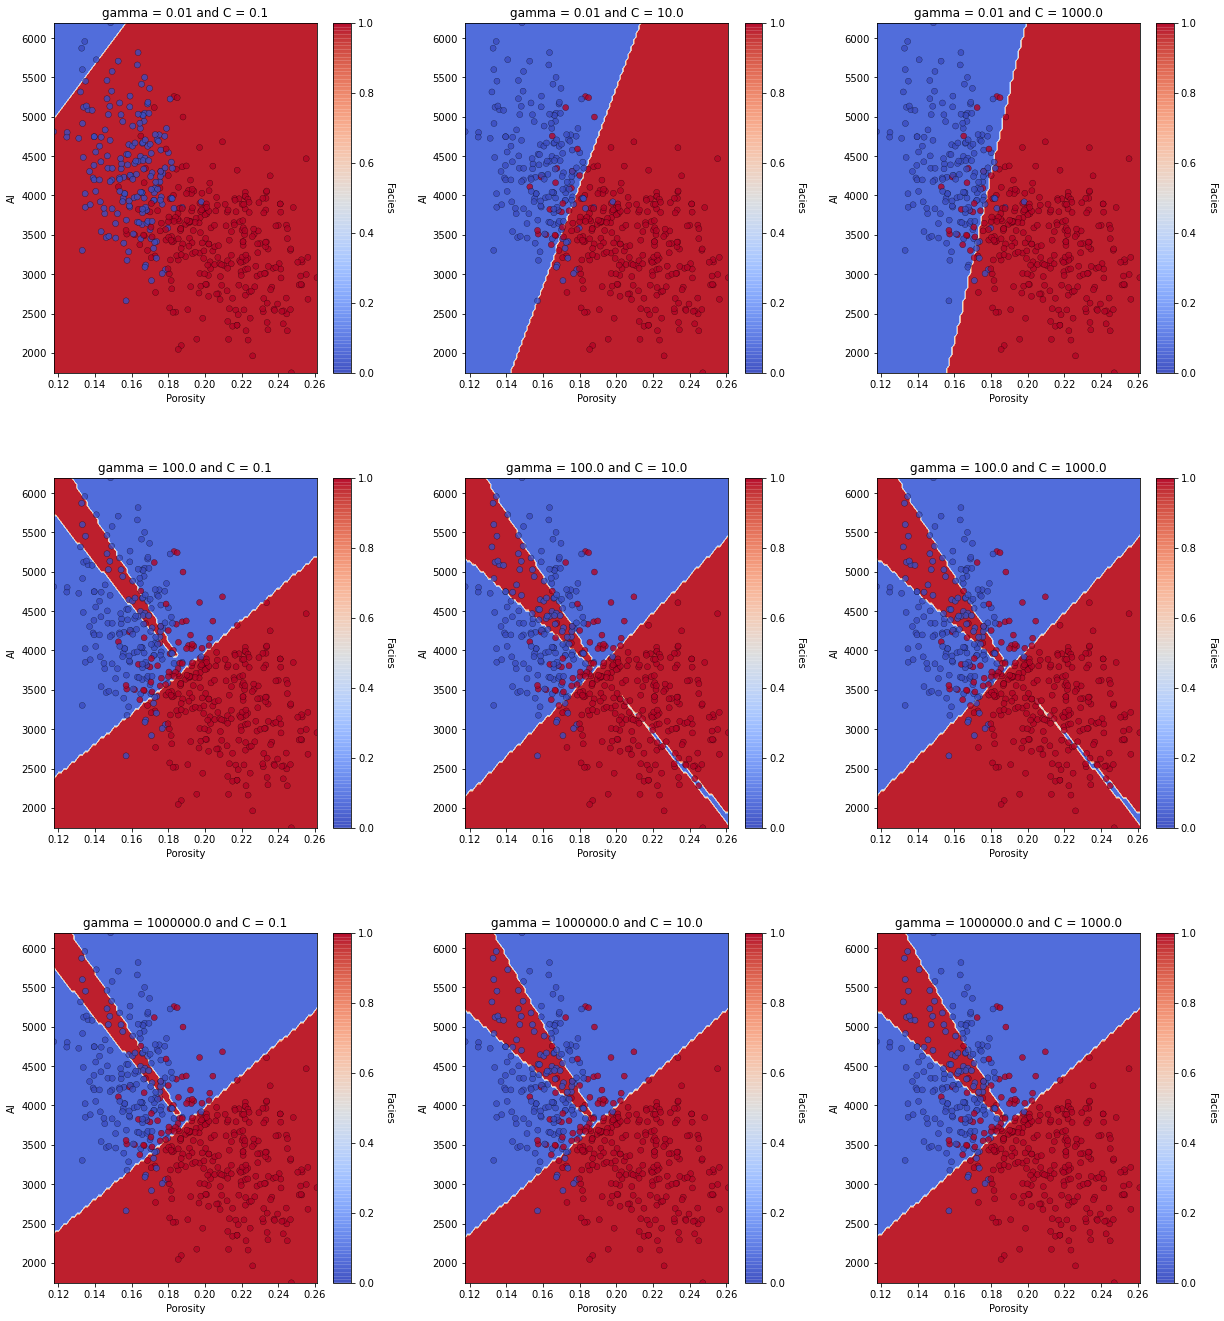

In [36]:
Carr = np.logspace(-1, 3, 3)
gammaarr = np.logspace(-2, 6, 3)
shc=int(np.shape(Carr)[0])
sha=int(np.shape(gammaarr)[0])
plt.figure(figsize=(8, 7))

for j in range(sha):
    for i in range(shc):
        k=i+j*shc
        svm_sigmoid = SVC(kernel = 'sigmoid', gamma = gammaarr[j], random_state=0,C = Carr[i])
        svm_sigmoid.fit(df.loc[:,['nPorosity','nAI']], df.loc[:,'Facies'])
        plt.subplot(sha,shc,k+1)
        plt = visualize_model(svm_sigmoid,df["nPorosity"],df["nAI"],df["Porosity"],df["AI"],df["Facies"])
        plt.title('gamma = '+str(gammaarr[j])+' and C = '+str(Carr[i]))
        plot_svc_decision_function(svm_sigmoid,plt, plot_support=False)
plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=2.5, wspace=0.25, hspace=0.3)

We could see that with higher C and $\gamma$, our model tends to overfit.
Let us do train-test-tune processes to find the optimum model.

In [38]:
Carr = np.logspace(-1, 7, 9)
gammaarr = np.logspace(-5, 1, 7)
param_grid = dict(gamma=gammaarr, C=Carr)
cv = StratifiedShuffleSplit(n_splits=5, test_size=0.3, random_state=4) #random train-test split for 5 times
grid = GridSearchCV(SVC(kernel = 'sigmoid'), param_grid=param_grid, cv=cv)
grid.fit(df.loc[:,['nPorosity','nAI']], df['Facies'])
scores = grid.cv_results_['mean_test_score'].reshape(len(Carr),len(gammaarr))

Text(0.5, 1.0, 'Validation accuracy')

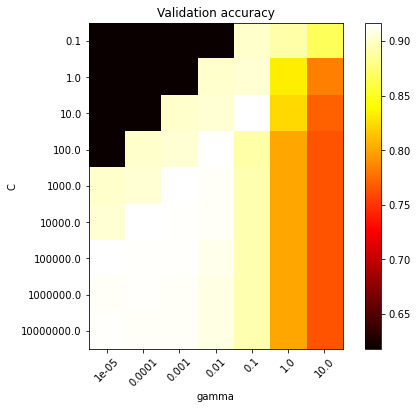

In [39]:
plt.figure(figsize=(8, 6))    
plt.imshow(scores, cmap=plt.cm.hot)
plt.xlabel('gamma')
plt.ylabel('C')
plt.colorbar()
plt.xticks(np.arange(len(gammaarr)), gammaarr, rotation=45)
plt.yticks(np.arange(len(Carr)), Carr)
plt.title('Validation accuracy')

The optimum hyperparameter combination is:

In [40]:
print('The maximum score is: ' + str(np.max(scores)) + '.')
print('The position of maximum score is: '+str(unravel_index(scores.argmax(), scores.shape))+'.')

The maximum score is: 0.9166666666666667.
The position of maximum score is: (2, 4).


The optimum C=1000, $\gamma$=0.001. Then we will train our whole datasets based on the optimum hyperparameters.

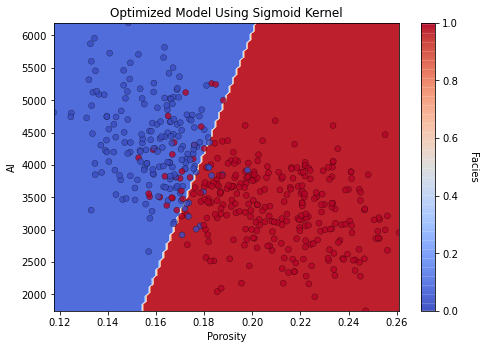

In [41]:
svm_sigmoid = SVC(kernel = 'sigmoid', gamma = 0.001, random_state=0,C = 1000)
svm_sigmoid.fit(df.loc[:,['nPorosity','nAI']], df.loc[:,'Facies'])
plt = visualize_model(svm_sigmoid,df["nPorosity"],df["nAI"],df["Porosity"],df["AI"],df["Facies"])
plt.title('Optimized Model Using Sigmoid Kernel')
plot_svc_decision_function(svm_sigmoid,plt, plot_support=False)
plt.subplots_adjust(left=0.0, bottom=0.0, right=1.0, top=1.0, wspace=0.2, hspace=0.2)

The predicted decision boundary looks linear! With a very small $\gamma$, Sigmoid kernel can tackle with the linear decision boundary problem. This agrees with our common sense: y=tanh(x) ~ x when x approach 0.

### 2nd Pattern with Circular Decision Boundary

In the following parts we are going to evaluate the performances of different kernels on different types of patterns. First, we will look at the pattern with a circular decision boundary. 

To avoid pleonatic steps, we will just visualize the model with optimum hyperparameters. All the optimum hyperparameters are from rerunning the previous steps with other patterns. Note that some kernels do not perform well on some patterns. The training process is very unstable, which will take a long time in the train-test-tune process. Please feel free to test by yourself.

Optimum hyperparameter list (if available):  
Linear kernel: Does not perform well.  
Polynomial kernel: C = 10000, Degree = 2.
Gaussian kernel: C = 1000 ; $\gamma$ = 0.1  
Laplacian kernel: C = 0.1 or 1; $\gamma$: does not sensitive.  
Sigmoid kernel: Does not perform well.  

Then we plot the optimum cases for well-tuned kernels, while plot the underperformed cases with assumed good hyperparameters either by common sense or by better visualization.

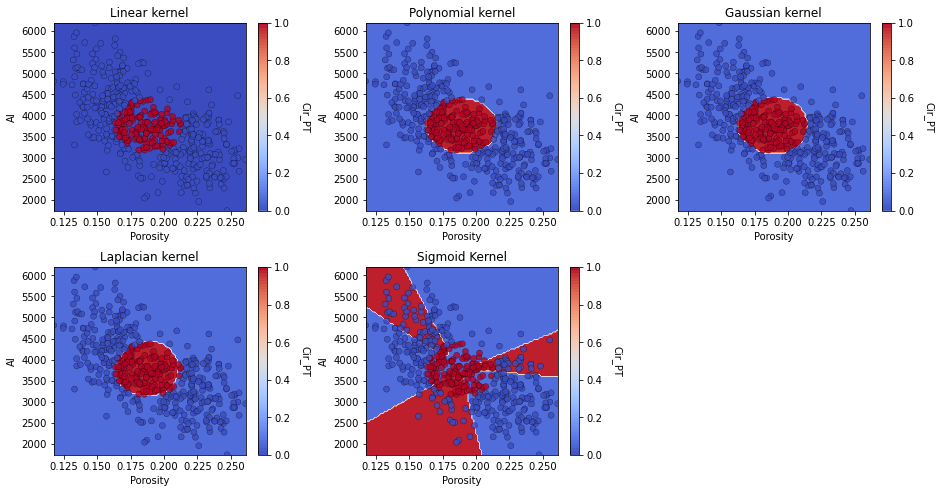

In [53]:
plt.figure(figsize=(12, 6))

#linear kernel
plt.subplot(2,3,1)
svm_linear10 = SVC(kernel = 'linear',C = 10**2, random_state = 0)    # Create a SVC classifier using a linear kernel
svm_linear10.fit(df.loc[:,['nPorosity','nAI']], df.loc[:,'Cir_PT'])    # Train the classifier
plt = visualize_model(svm_linear10,df["nPorosity"],df["nAI"],df["Porosity"],df["AI"],df["Cir_PT"])
plt.title("Linear kernel")

#polynomial kernel
plt.subplot(2,3,2)
svm_poly = SVC(kernel = 'poly', degree = 2, random_state=0, C = 10**4)
svm_poly.fit(df.loc[:,['nPorosity','nAI']], df.loc[:,'Cir_PT'])
plt = visualize_model(svm_poly,df["nPorosity"],df["nAI"],df["Porosity"],df["AI"],df["Cir_PT"])
plt.title("Polynomial kernel")

#Gaussian kernel
plt.subplot(2,3,3)
clf = SVC(kernel = 'rbf',C=1000, gamma=0.1)
clf.fit(df.loc[:,['nPorosity','nAI']], df.loc[:,'Cir_PT'])
plt = visualize_model(clf,df["nPorosity"],df["nAI"],df["Porosity"],df["AI"],df["Cir_PT"])
plt.title("Gaussian kernel")

#Laplacian kernel
plt.subplot(2,3,4)
clf = SVC(kernel = pairwise.laplacian_kernel,C=0.1, gamma=1)
clf.fit(df.loc[:,['nPorosity','nAI']], df.loc[:,'Cir_PT'])
plt = visualize_model(clf,df["nPorosity"],df["nAI"],df["Porosity"],df["AI"],df["Cir_PT"])
plt.title("Laplacian kernel")

#Sigmoid kernel
plt.subplot(2,3,5)
svm_sigmoid = SVC(kernel = 'sigmoid', gamma = 10, random_state=0,C = 1)
svm_sigmoid.fit(df.loc[:,['nPorosity','nAI']], df.loc[:,'Cir_PT'])
plt = visualize_model(svm_sigmoid,df["nPorosity"],df["nAI"],df["Porosity"],df["AI"],df["Cir_PT"])
plt.title('Sigmoid Kernel')
                                                      
plt.subplots_adjust(left=0.0, bottom=0.0, right=1.0, top=1.0, wspace=0.3, hspace=0.3)

We see that both RBF kernels and polynomial kernel could handle isolated and curved decision boundary recognition, while others do not perform well.

### 3rd Pattern with Stripe Decision Boundary

The 3rd decision boundary is stripe-like, which is not continuous for one facies and continuous for the other. 

Optimum hyperparameter list (if available):  
Linear kernel: Does not perform well.  
Polynomial kernel: C = 100, Degree = 2.  
Gaussian kernel: C = 1000 ; $\gamma$ = 0.1  
Laplacian kernel: C $\ge$ 10; $\gamma$: does not sensitive.  
Sigmoid kernel: Does not perform well.  

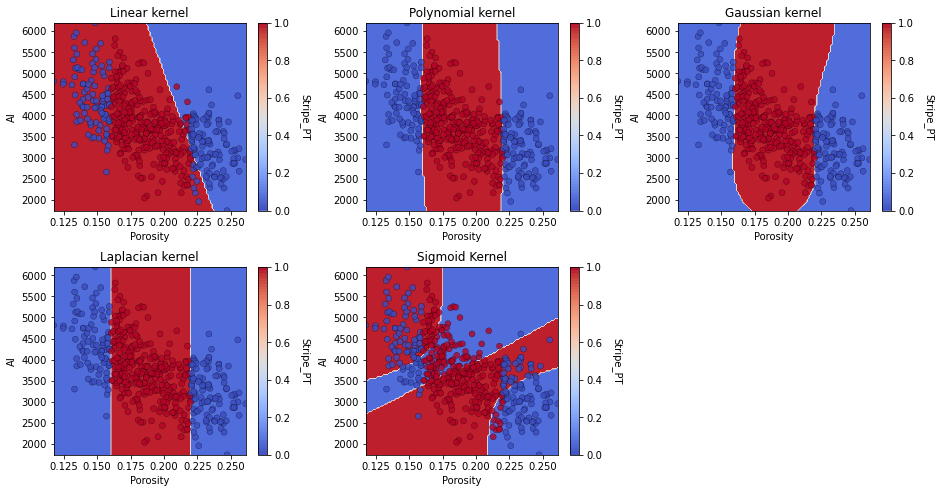

In [56]:
plt.figure(figsize=(12, 6))

#linear kernel
plt.subplot(2,3,1)
svm_linear10 = SVC(kernel = 'linear',C = 10**2, random_state = 0)    # Create a SVC classifier using a linear kernel
svm_linear10.fit(df.loc[:,['nPorosity','nAI']], df.loc[:,'Stripe_PT'])    # Train the classifier
plt = visualize_model(svm_linear10,df["nPorosity"],df["nAI"],df["Porosity"],df["AI"],df["Stripe_PT"])
plt.title("Linear kernel")

#polynomial kernel
plt.subplot(2,3,2)
svm_poly = SVC(kernel = 'poly', degree = 2, random_state=0, C = 100)
svm_poly.fit(df.loc[:,['nPorosity','nAI']], df.loc[:,'Stripe_PT'])
plt = visualize_model(svm_poly,df["nPorosity"],df["nAI"],df["Porosity"],df["AI"],df["Stripe_PT"])
plt.title("Polynomial kernel")

#Gaussian kernel
plt.subplot(2,3,3)
clf = SVC(kernel = 'rbf',C=1000, gamma=0.1)
clf.fit(df.loc[:,['nPorosity','nAI']], df.loc[:,'Stripe_PT'])
plt = visualize_model(clf,df["nPorosity"],df["nAI"],df["Porosity"],df["AI"],df["Stripe_PT"])
plt.title("Gaussian kernel")

#Laplacian kernel
plt.subplot(2,3,4)
clf = SVC(kernel = pairwise.laplacian_kernel,C=100, gamma=1)
clf.fit(df.loc[:,['nPorosity','nAI']], df.loc[:,'Stripe_PT'])
plt = visualize_model(clf,df["nPorosity"],df["nAI"],df["Porosity"],df["AI"],df["Stripe_PT"])
plt.title("Laplacian kernel")

#Sigmoid kernel
plt.subplot(2,3,5)
svm_sigmoid = SVC(kernel = 'sigmoid', gamma = 1, random_state=0,C = 100)
svm_sigmoid.fit(df.loc[:,['nPorosity','nAI']], df.loc[:,'Stripe_PT'])
plt = visualize_model(svm_sigmoid,df["nPorosity"],df["nAI"],df["Porosity"],df["AI"],df["Stripe_PT"])
plt.title('Sigmoid Kernel')
                                                      
plt.subplots_adjust(left=0.0, bottom=0.0, right=1.0, top=1.0, wspace=0.3, hspace=0.3)

We see that Laplacian kernel do very well on stripe-like pattern. Gaussian kernel and polynomial kernel does perferm well, but others do not.

### 4th Pattern with Diagonal Decision Boundary

The 4th decision boundary is diagonal-like in a square, which is not continuous for both facies, but the decision boundaries are straight.

Optimum hyperparameter list (if available):  
Linear kernel: Does not perform well.  
Polynomial kernel: C = 10000, Degree = 2.  
Gaussian kernel: C = 10E10 ; $\gamma$ = 0.01  
Laplacian kernel: C $\ge$ 10 or 1; $\gamma$: does not sensitive.  
Sigmoid kernel: C = 100 ; $\gamma$ = 0.01.  

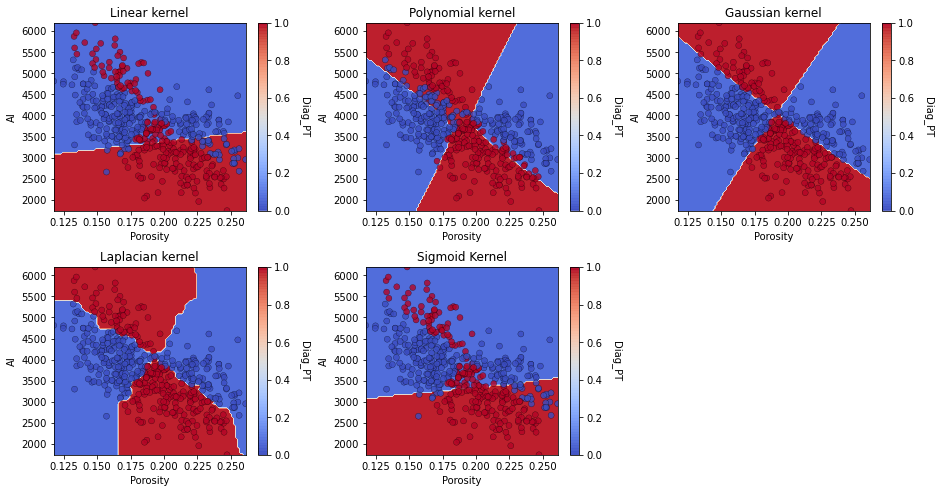

In [79]:
plt.figure(figsize=(12, 6))

#linear kernel
plt.subplot(2,3,1)
svm_linear10 = SVC(kernel = 'linear',C = 1, random_state = 0)    # Create a SVC classifier using a linear kernel
svm_linear10.fit(df.loc[:,['nPorosity','nAI']], df.loc[:,'Diag_PT'])    # Train the classifier
plt = visualize_model(svm_linear10,df["nPorosity"],df["nAI"],df["Porosity"],df["AI"],df["Diag_PT"])
plt.title("Linear kernel")

#polynomial kernel
plt.subplot(2,3,2)
svm_poly = SVC(kernel = 'poly', degree = 2, random_state=0, C = 10000)
svm_poly.fit(df.loc[:,['nPorosity','nAI']], df.loc[:,'Diag_PT'])
plt = visualize_model(svm_poly,df["nPorosity"],df["nAI"],df["Porosity"],df["AI"],df["Diag_PT"])
plt.title("Polynomial kernel")

#Gaussian kernel
plt.subplot(2,3,3)
clf = SVC(kernel = 'rbf',C=10**10, gamma=0.01)
clf.fit(df.loc[:,['nPorosity','nAI']], df.loc[:,'Diag_PT'])
plt = visualize_model(clf,df["nPorosity"],df["nAI"],df["Porosity"],df["AI"],df["Diag_PT"])
plt.title("Gaussian kernel")

#Laplacian kernel
plt.subplot(2,3,4)
clf = SVC(kernel = pairwise.laplacian_kernel,C=100, gamma=1)
clf.fit(df.loc[:,['nPorosity','nAI']], df.loc[:,'Diag_PT'])
plt = visualize_model(clf,df["nPorosity"],df["nAI"],df["Porosity"],df["AI"],df["Diag_PT"])
plt.title("Laplacian kernel")

#Sigmoid kernel
plt.subplot(2,3,5)
svm_sigmoid = SVC(kernel = 'sigmoid', gamma = 0.01, random_state=0,C = 100)
svm_sigmoid.fit(df.loc[:,['nPorosity','nAI']], df.loc[:,'Diag_PT'])
plt = visualize_model(svm_sigmoid,df["nPorosity"],df["nAI"],df["Porosity"],df["AI"],df["Diag_PT"])
plt.title('Sigmoid Kernel')
                                                      
plt.subplots_adjust(left=0.0, bottom=0.0, right=1.0, top=1.0, wspace=0.3, hspace=0.3)

We see that for diagnonal pattern, Gaussian kernel performs the best. Polynomial kernel and Laplacian kernel do track the decision boundary, but looks underfit and overfit, respectively. Linear kernel and Sigmoid kernel do not perform well.

### Summary of Effect of Kernel Type on the Original Linear Pattern

We notice that with their optimum hyperparameters, kernels of different types could determine the linear decision boundary very well. For the isolated circular decision boundary, polynomial, Gaussian, and Laplacian kernels work well. For the striped decision boundary, Laplacian and polynomial kernels work very well, followed by Gaussian kernel. Last, for the diagonal pattern, Gaussian and Laplacian kernels work very well, followed by polynomial kernel. It is perceived that polynomial, Guassian, and Laplacian kernels are suitable for more complicated decision boundaries than linear ones.

I hope this was helpful,

*Ruoyu Li*

___________________

### Ruoyu Li, PhD Aspirant, University of Texas at Austin 

Ruoyu is intensively conducting research on reservoir simulations of Enhanced Oil Recovery under Dr. Mohanty, Kishore's supervision. He is very interested in statistics and eagerly looking for an internship to work with the industry.




#### Work Supervised by:

### Michael Pyrcz, Associate Professor, University of Texas at Austin 
*Novel Data Analytics, Geostatistics and Machine Learning Subsurface Solutions*

With over 17 years of experience in subsurface consulting, research and development, Michael has returned to academia driven by his passion for teaching and enthusiasm for enhancing engineers' and geoscientists' impact in subsurface resource development. 

For more about Michael check out these links:

#### [Twitter](https://twitter.com/geostatsguy) | [GitHub](https://github.com/GeostatsGuy) | [Website](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) | [YouTube](https://www.youtube.com/channel/UCLqEr-xV-ceHdXXXrTId5ig)  | [LinkedIn](https://www.linkedin.com/in/michael-pyrcz-61a648a1)

#### Want to Work Together?

I hope this content is helpful to those that want to learn more about subsurface modeling, data analytics and machine learning. Students and working professionals are welcome to participate.

* Want to invite me to visit your company for training, mentoring, project review, workflow design and / or consulting? I'd be happy to drop by and work with you! 

* Interested in partnering, supporting my graduate student research or my Subsurface Data Analytics and Machine Learning consortium (co-PIs including Profs. Foster, Torres-Verdin and van Oort)? My research combines data analytics, stochastic modeling and machine learning theory with practice to develop novel methods and workflows to add value. We are solving challenging subsurface problems!

* I can be reached at mpyrcz@austin.utexas.edu.

I'm always happy to discuss,

*Michael*

Michael Pyrcz, Ph.D., P.Eng. Associate Professor The Hildebrand Department of Petroleum and Geosystems Engineering, Bureau of Economic Geology, The Jackson School of Geosciences, The University of Texas at Austin
